In [6]:
import sys; sys.path.append("..")
from dataset import AppleQualityDataset, Library
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch, MmhcEstimator, ExhaustiveSearch
import bnlearn as bn
import matplotlib.pyplot as plt

data = AppleQualityDataset(data_path="../data/apple_quality.csv", seed=42)

In [2]:
display(data.train_df.head())
display(data.test_df.head())

,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
3012,0,1,1,0,0,2,1,0
1436,1,0,0,1,2,2,0,0
96,1,0,0,0,2,2,0,0
43,2,2,1,1,0,0,1,0
1814,0,2,0,1,0,2,2,0


,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
555,2,0,0,1,1,2,1,1
3491,2,2,1,1,1,0,2,0
527,2,1,2,1,0,0,2,0
3925,0,1,2,0,0,2,1,1
2989,0,1,0,0,0,2,0,0


In [3]:
def createPgmpyBN(dag: DAG, data) -> BayesianNetwork:
    model = BayesianNetwork()
    model.add_edges_from(dag.edges())
    model.fit(data.train_df)
    return model


def createBnlearnBN(dag: dict, data) -> dict:
    return bn.parameter_learning.fit(dag, data.train_df, methodtype="ml", verbose=0)

# Manually defined
---

Accuracy: 0.701


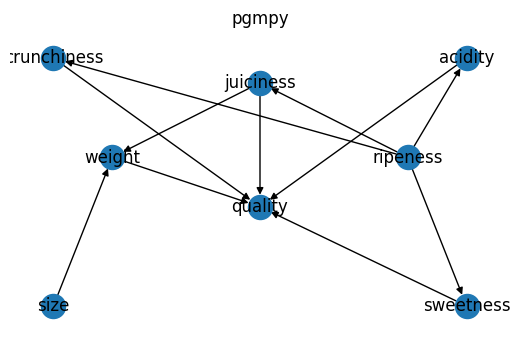

In [4]:
model = BayesianNetwork([
    ("ripeness", "crunchiness"),
    ("ripeness", "sweetness"),
    ("ripeness", "juiciness"),
    ("ripeness", "acidity"),
    ("size", "weight"),
    ("juiciness", "weight"),
    ("juiciness", "quality"),
    ("crunchiness", "quality"),
    ("acidity", "quality"),
    ("sweetness", "quality"),
    ("weight", "quality"),
])
model.fit(data.train_df)

infer = VariableElimination(model)
print(f"Accuracy: {data.evaluate(model, Library.PGMPY)}")

plt.figure(figsize=(5, 3))
data.plot(model, Library.PGMPY)
plt.show()

# Constraint-based
---

## PC

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:55<00:00, 11.01s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:55<00:00, 11.02s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:54<00:00, 10.97s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.


pgmpy accuracy: 0.757
bnlearn accuracy: 0.757


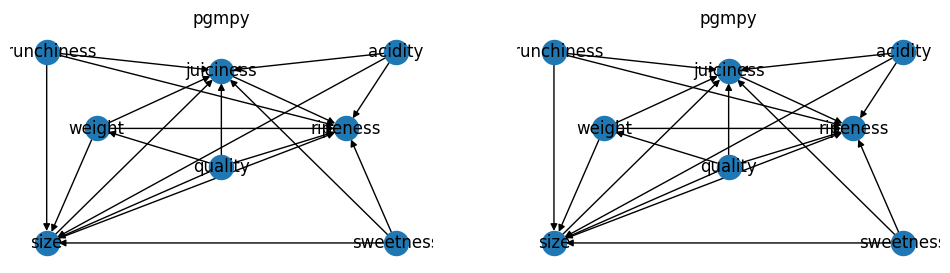

In [5]:
dag_pgmpy = PC(data=data.train_df).estimate(variant="stable", ci_test="chi_square", significance_level=0.05, max_cond_vars=5)
pgmpy_accuracy = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="cs", verbose=0)
bnlearn_accuracy = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy accuracy: {pgmpy_accuracy}")
print(f"bnlearn accuracy: {bnlearn_accuracy}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

# Score-based
---

## Hill-climb search

  0%|          | 17/1000000 [00:00<3:06:43, 89.25it/s]


pgmpy accuracy: 0.802
bnlearn accuracy: 0.802


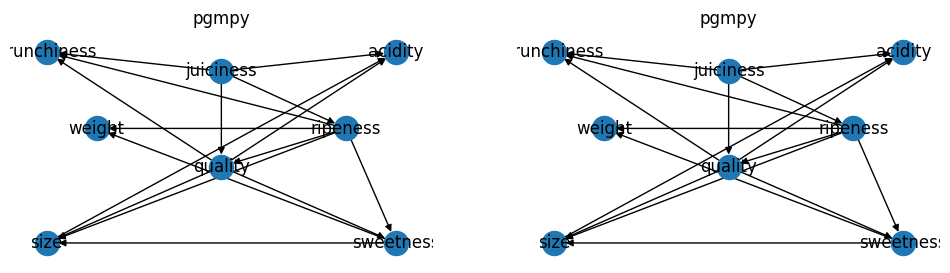

In [6]:
dag_pgmpy = HillClimbSearch(data=data.train_df).estimate(scoring_method="bicscore")
pgmpy_accuracy = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="hc", scoretype="bic", verbose=0)
bnlearn_accuracy = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy accuracy: {pgmpy_accuracy}")
print(f"bnlearn accuracy: {bnlearn_accuracy}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Max-min hill-climbing

  0%|          | 17/1000000 [00:00<2:21:58, 117.39it/s]


Accuracy: 0.794


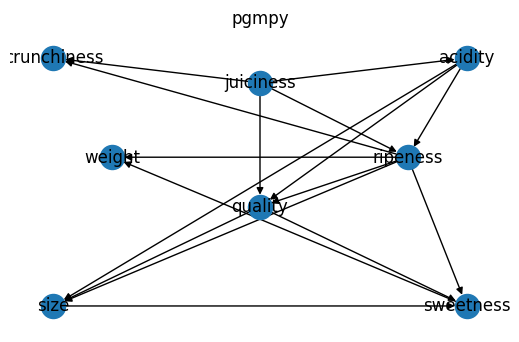

In [7]:
dag_pgmpy = MmhcEstimator(data=data.train_df).estimate()
print(f"Accuracy: {data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)}")

plt.figure(figsize=(5, 3))
data.plot(dag_pgmpy, Library.PGMPY)
plt.show()

# Tree-based
---

## Chow-Liu

Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 7146.19it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 10825.01it/s]


pgmpy accuracy: 0.705
bnlearn accuracy: 0.705


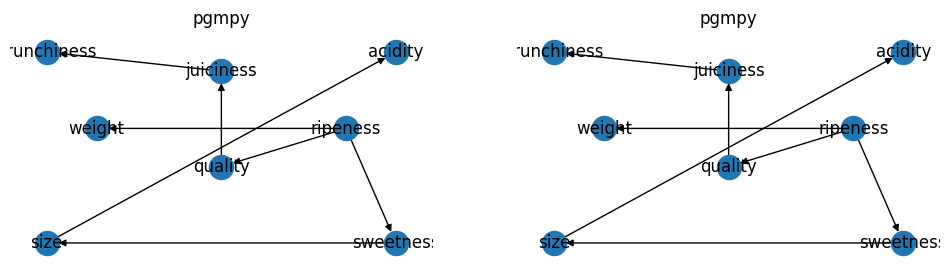

In [8]:
dag_pgmpy = TreeSearch(data=data.train_df).estimate(estimator_type="chow-liu")
pgmpy_accuracy = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="cl", verbose=0)
bnlearn_accuracy = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy accuracy: {pgmpy_accuracy}")
print(f"bnlearn accuracy: {bnlearn_accuracy}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Naive Bayes

pgmpy accuracy: 0.715
bnlearn accuracy: 0.715


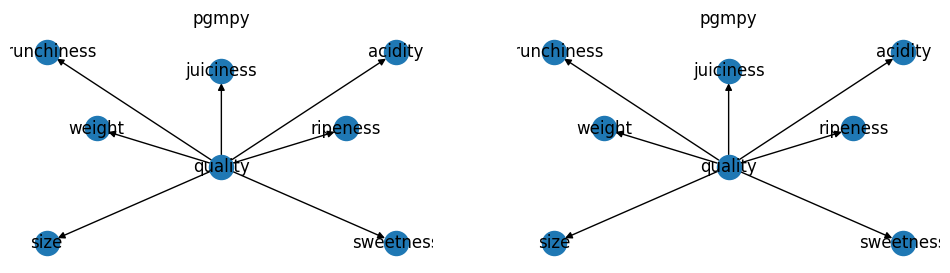

In [9]:
dag_pgmpy = NaiveBayes(data.features, data.target)
pgmpy_accuracy = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="naivebayes", root_node=data.target, verbose=0)
bnlearn_accuracy = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy accuracy: {pgmpy_accuracy}")
print(f"bnlearn accuracy: {bnlearn_accuracy}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Tree-augmented naive Bayes

Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 13779.25it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 12325.83it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 15989.18it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 40510.70it/s]


pgmpy accuracy: 0.719
bnlearn accuracy: 0.719


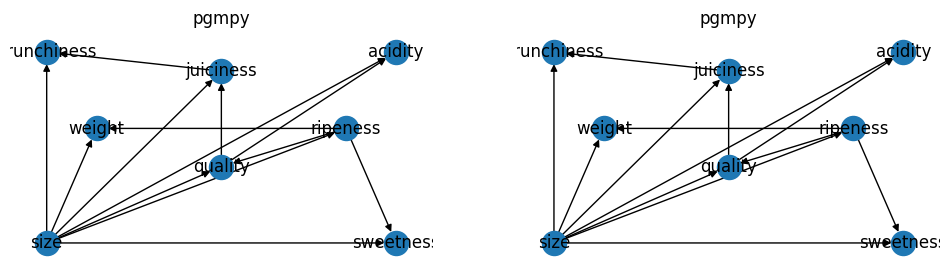

In [10]:
dag_pgmpy = TreeSearch(data=data.train_df).estimate(estimator_type="tan", class_node=data.features[0])
pgmpy_accuracy = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="tan", class_node=data.features[0], verbose=0)
bnlearn_accuracy = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy accuracy: {pgmpy_accuracy}")
print(f"bnlearn accuracy: {bnlearn_accuracy}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()